In [14]:

import numpy as np
# print version of numpy
print(np.__version__)



1.23.5


In [15]:
import os
import random
import shutil
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, \
    GlobalAveragePooling2D, Multiply, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


# Split the dataset into train, validation, and test
def split_data(source_dir, train_dir, val_dir, test_dir, train_ratio, validation_ratio):
    """
    Splits data from source_dir into train, validation, and test directories.

    Args:
        source_dir (str): Path to the source dataset directory.
        train_dir (str): Path to the training data directory.
        val_dir (str): Path to the validation data directory.
        test_dir (str): Path to the test data directory.
        train_ratio (float): Proportion of data to be used for training.
        validation_ratio (float): Proportion of data to be used for validation.
    """
    test_ratio = 1 - train_ratio - validation_ratio

    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if not os.path.isdir(category_path):
            continue

        # Create subdirectories for each split
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        images = os.listdir(category_path)
        random.shuffle(images)

        total_images = len(images)
        train_count = int(total_images * train_ratio)
        val_count = int(total_images * validation_ratio)

        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        # Copy images to train folder
        for image in train_images:
            src = os.path.join(category_path, image)
            dst = os.path.join(train_dir, category, image)
            shutil.copy(src, dst)

        # Copy images to validation folder
        for image in val_images:
            src = os.path.join(category_path, image)
            dst = os.path.join(val_dir, category, image)
            shutil.copy(src, dst)

        # Copy images to test folder
        for image in test_images:
            src = os.path.join(category_path, image)
            dst = os.path.join(test_dir, category, image)
            shutil.copy(src, dst)



In [16]:
# Update data generator to support categorical classification
def create_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )

    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

In [17]:
# Spatial Attention
def spatial_attention(inputs):
    avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    return Multiply()([inputs, attention])


# Attention mechanism to focus on critical regions
def attention_layer(inputs):
    attention = GlobalAveragePooling2D()(inputs)
    attention = Dense(inputs.shape[-1], activation='sigmoid')(attention)
    attention = Reshape((1, 1, inputs.shape[-1]))(attention)
    return Multiply()([inputs, attention])

In [18]:
# Build the model
def build_model(input_shape=(224, 224, 3)):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # First convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)

    # Second convolutional block with spatial attention
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)
    x = spatial_attention(x)

    # Third convolutional block with attention
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)
    x = attention_layer(x)

    # Fourth convolutional block with attention
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)
    x = attention_layer(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer for 4 classes
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [19]:
# Train the model
def train_model(model, train_generator, val_generator, epochs=20, learning_rate=0.0001):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)
    return history


In [20]:
# Fine-tune the model
def fine_tune_model(model, train_generator, val_generator, fine_tune_epochs=10, fine_tune_lr=1e-5):
    for layer in model.layers[-6:]:
        layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=fine_tune_lr),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    history_fine = model.fit(train_generator, epochs=fine_tune_epochs, validation_data=val_generator)
    return history_fine

In [21]:
# Evaluate the model
def evaluate_model(model, test_generator):
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [22]:
# Generate Grad-CAM heatmaps
def generate_grad_cam(model, image, layer_name):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


# Overlay Grad-CAM heatmap on image
def overlay_heatmap(heatmap, original_image):
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)
    return overlay

In [23]:
# Visualize Grad-CAM
def visualize_grad_cam(model, test_generator, layer_name):
    test_images, _ = next(test_generator)

    for i in range(min(len(test_images), 5)):
        img = np.expand_dims(test_images[i], axis=0)
        heatmap = generate_grad_cam(model, img, layer_name)
        overlay = overlay_heatmap(heatmap, (test_images[i] * 255).astype(np.uint8))

        # Plot original image, heatmap, and overlay
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[i])
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title("Grad-CAM Heatmap")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title("Overlay Heatmap")
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(f"academic_grad_cam_{i}.png")
        plt.show()

In [24]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy Over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Loss Over Epochs")
    plt.show()

In [25]:
# Main function
def main():
    set_seed()

    # Set the random seed
    random.seed(42)

    dataset_path = r'C:\Users\User\Desktop\Diseases\Dataset'
    train_dir = os.path.join(dataset_path, 'train')
    val_dir = os.path.join(dataset_path, 'val')
    test_dir = os.path.join(dataset_path, 'test')

    # Define the split ratios
    train_ratio = 0.7
    valid_ratio = 0.15

    # Split the dataset
    # split_data(dataset_path, train_dir, val_dir, test_dir, train_ratio, valid_ratio)

    # Create data generators
    train_generator, val_generator, test_generator = create_generators(train_dir, val_dir, test_dir)

    # Build model
    model = build_model()

    # Train model
    history = train_model(model, train_generator, val_generator)
    plot_history(history)

    # Fine-tune model
    history_fine = fine_tune_model(model, train_generator, val_generator)
    plot_history(history_fine)

    # Evaluate model
    evaluate_model(model, test_generator)

    # Grad-CAM visualization
    try:
        visualize_grad_cam(model, test_generator, layer_name="conv2d_3")
    except Exception as e:
        print(f"Grad-CAM visualization failed due to an error: {e}")

    # Save model
    model.save("analeyes_model_multi_classification.h5")
    print("Model saved as analeyes_model_multi_classification.h5")

Found 36464 images belonging to 4 classes.
Found 7812 images belonging to 4 classes.
Found 7820 images belonging to 4 classes.
Epoch 1/20
1140/1140 [==============================] - 348s 302ms/step - loss: 0.9452 - categorical_accuracy: 0.5614 - val_loss: 0.7568 - val_categorical_accuracy: 0.6531
Epoch 2/20
1140/1140 [==============================] - 218s 191ms/step - loss: 0.7168 - categorical_accuracy: 0.6897 - val_loss: 0.6977 - val_categorical_accuracy: 0.7206
Epoch 3/20
1140/1140 [==============================] - 214s 188ms/step - loss: 0.5976 - categorical_accuracy: 0.7554 - val_loss: 0.5218 - val_categorical_accuracy: 0.7905
Epoch 4/20
1140/1140 [==============================] - 209s 183ms/step - loss: 0.4983 - categorical_accuracy: 0.8039 - val_loss: 0.4382 - val_categorical_accuracy: 0.8283
Epoch 5/20
1140/1140 [==============================] - 209s 184ms/step - loss: 0.4304 - categorical_accuracy: 0.8340 - val_loss: 0.4132 - val_categorical_accuracy: 0.8425
Epoch 6/20
11

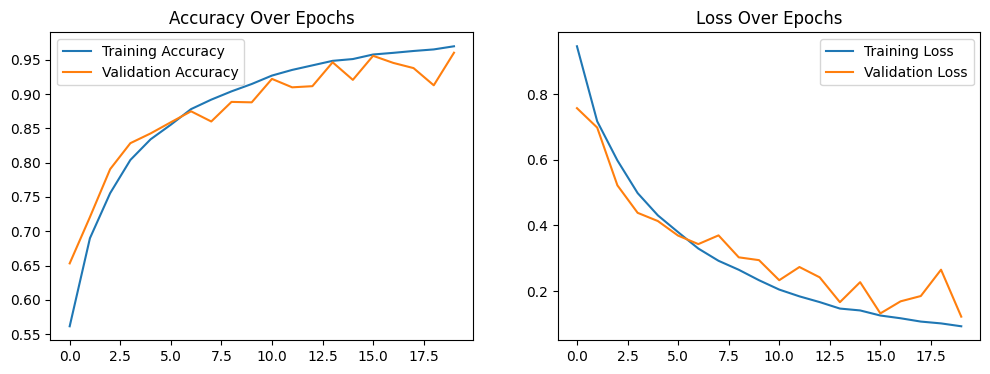

Epoch 1/10
1140/1140 [==============================] - 215s 188ms/step - loss: 0.0579 - categorical_accuracy: 0.9819 - val_loss: 0.0871 - val_categorical_accuracy: 0.9752
Epoch 2/10
1140/1140 [==============================] - 213s 187ms/step - loss: 0.0493 - categorical_accuracy: 0.9845 - val_loss: 0.0879 - val_categorical_accuracy: 0.9750
Epoch 3/10
1140/1140 [==============================] - 213s 187ms/step - loss: 0.0491 - categorical_accuracy: 0.9852 - val_loss: 0.0896 - val_categorical_accuracy: 0.9745
Epoch 4/10
1140/1140 [==============================] - 213s 186ms/step - loss: 0.0429 - categorical_accuracy: 0.9868 - val_loss: 0.0848 - val_categorical_accuracy: 0.9754
Epoch 5/10
1140/1140 [==============================] - 215s 189ms/step - loss: 0.0435 - categorical_accuracy: 0.9866 - val_loss: 0.0825 - val_categorical_accuracy: 0.9775
Epoch 6/10
1140/1140 [==============================] - 211s 185ms/step - loss: 0.0410 - categorical_accuracy: 0.9867 - val_loss: 0.0872 - v

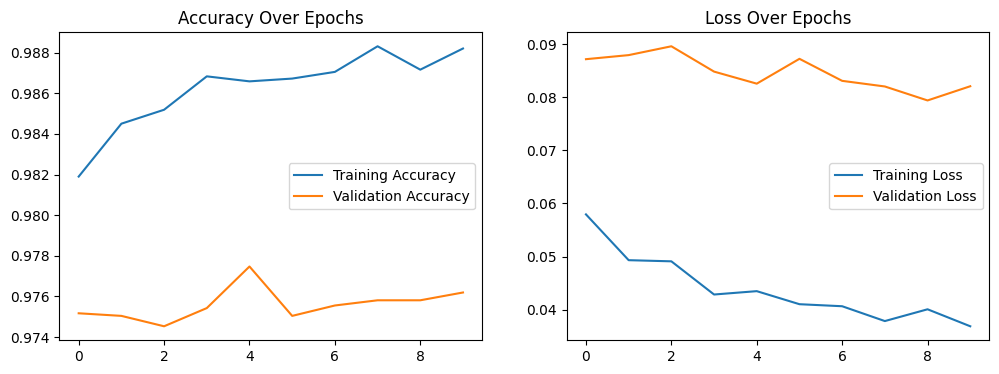

245/245 [==============================] - 31s 126ms/step - loss: 0.0742 - categorical_accuracy: 0.9790
Test Accuracy: 97.90%
245/245 [==============================] - 10s 41ms/step
                precision    recall  f1-score   support

      Cataract       0.97      0.98      0.98      1955
Conjunctivitis       0.99      0.98      0.98      1955
       Healthy       0.98      0.96      0.97      1955
          Stye       0.97      0.99      0.98      1955

      accuracy                           0.98      7820
     macro avg       0.98      0.98      0.98      7820
  weighted avg       0.98      0.98      0.98      7820



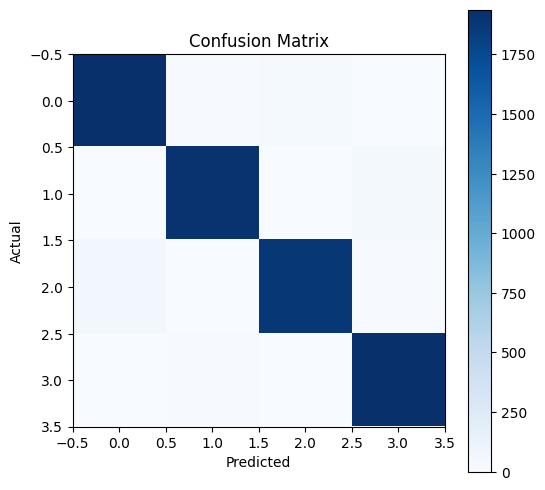

Grad-CAM visualization failed due to an error: No such layer: conv2d_3. Existing layers are: ['input_2', 'conv2d_5', 'batch_normalization_4', 'max_pooling2d_4', 'conv2d_6', 'batch_normalization_5', 'max_pooling2d_5', 'tf.math.reduce_mean_1', 'tf.math.reduce_max_1', 'concatenate_1', 'conv2d_7', 'multiply_3', 'conv2d_8', 'batch_normalization_6', 'max_pooling2d_6', 'global_average_pooling2d_3', 'dense_5', 'reshape_2', 'multiply_4', 'conv2d_9', 'batch_normalization_7', 'max_pooling2d_7', 'global_average_pooling2d_4', 'dense_6', 'reshape_3', 'multiply_5', 'global_average_pooling2d_5', 'dense_7', 'dropout_2', 'dense_8', 'dropout_3', 'dense_9'].
Model saved as analeyes_model_multi_classification.h5


In [26]:
if __name__ == "__main__":
    main()